Отключаем все предупреждения, чтобы они не мешали при анализе данных.

In [17]:
import warnings
warnings.filterwarnings('ignore')

Импортируем библиотеки для: работы с данными, анализа данных, балансировки данных, классификаторы, методы кросс-валидации и т.д.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from typing import Any

import sklearn
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, f1_score, balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, TomekLinks, ClusterCentroids
from imblearn.combine import SMOTEENN, SMOTETomek

Функция для балансировки данных.
Принимает: метод балансировки данных, название балансировщика, признаки и целвую переменную.
Выводит: количество данных до и после балансировки.
Возвращает: сбалансированные данные.

In [19]:
def resemple_data(  
    balancing_alg: Any, 
    title: str, 
    x_before: pd.DataFrame,
    y_before: pd.Series,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    
    print(title)
    x_after, y_after = balancing_alg.fit_resample(x_before, y_before.ravel())
    
    print(f'Initial data : {Counter(y_before)}')
    print(f'Edited data : {Counter(y_after)}')

    return x_after, y_after

Функция строит точечные диаграммы.
Принимает: признаки и целевую переменную до балансировки и после.
Выводит: точечные диаграммы по 2 осям, до и после балансировки.
Возвращает: -

In [20]:
def scattering_matrix(
    x_after_sampling: pd.DataFrame,
    x_before_sampling: pd.DataFrame,
    y_after_sampling: pd.Series,
    y_before_sampling: pd.Series, 
    alg_name: str
) -> None:
    print(f'Training data before and after used {alg_name}')
    figure = plt.figure(figsize=(10, 10))

    ax_1 = figure.add_subplot(2, 2, 1)
    sns.scatterplot(data=x_before_sampling, x='a6', y='a5', hue=y_before_sampling, palette='Set1', s=100)
    ax_3 = figure.add_subplot(2, 2, 2)
    sns.scatterplot(data=x_after_sampling, x='a6', y='a5', hue=y_after_sampling, palette='Set1', s=100)

Функции для рассчета ложноположительных и ложноотрицательных предсказываний. Принимает: истинную целевую переменную и предсказанную переменную. Выводит: -. Возвращает: процент ложноположительных и ложноотрицательных предсказывааний.

In [21]:
def fp(y_true: pd.Series, y_pred: pd.Series): return confusion_matrix(y_true, y_pred, normalize='true')[0, 1]
def fn(y_true: pd.Series, y_pred: pd.Series): return confusion_matrix(y_true, y_pred, normalize='true')[1, 0] 
# normalize='true' матрица ошибок будет нормализована по строкам, что означает, что каждая строка матрицы будет суммироваться до 1. Это полезно для анализа относительной доли правильных и ошибочных классификаций для каждого истинного класса. Таким образом, значения в каждой строке матрицы ошибок будут представлять собой вероятности (относительные частоты) принадлежности каждого класса.

Функция производит кросс-валидацию данных,.
Принимает: классификатор, признаки и целевую переменную.
Выводит: классификатор, сбалансированную точность, точност, точность f1, ложноположительные предсказания, ложноотрицательные предсказания.
Возвращает: сбалансированную точность.

In [22]:
def cross_validating_score(classifier: Any, x: pd.DataFrame, y: pd.Series) -> float:
    scoring = {
        'balanced_accuracy': make_scorer(balanced_accuracy_score),
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score),
        'fp': make_scorer(fp),
        'fn': make_scorer(fn),
    }
    
    result = cross_validate(
        estimator=classifier,
        X=x, 
        y=y,
        scoring=scoring,
        cv=StratifiedKFold(10), 
        n_jobs=-1,
        return_train_score=False,
        return_estimator=True,
    )
    
    balanced_accuracy = np.round(100 * np.mean(result["test_balanced_accuracy"]), 2);
    
    print(f'Classifier: {classifier}')
    print(f'balanced accuracy: {balanced_accuracy}%')
    print(f'accuracy: {np.round(100 * np.mean(result["test_accuracy"]), 2)}%')
    print(f'f1: {np.round(100 * np.mean(result["test_f1"]), 2)}%')
    print(f'fp: {np.round(100 * np.mean(result["test_fp"]), 2)}%')
    print(f'fn: {np.round(100 * np.mean(result["test_fn"]), 2)}%')
    
    return balanced_accuracy, result['estimator']

Функция подбирает классификатор с оптимальными параметрами
Принимает: классификатор, гиперпараметры для классифатора, метод для поиска оптимальных гипперпараметров, 
признаки и целевую переменную.
Выводит: -
Возвращает: классификатор с подобранными оптимальными параметрами.

In [23]:
def get_classifier_with_best_params(
    classifier: Any, 
    parameters: dict[str, Any], 
    method: Any, 
    x: pd.DataFrame, 
    y: pd.Series
) -> Any:
    estimator = method(classifier(), parameters, cv=10, scoring='balanced_accuracy')
    estimator.fit(x, y)
    return estimator.best_estimator_

Функция производит выборку данных.
Принимает: алгоритм для отбора признаков, признаки и целевую переменную, список классификаторов.
Выводит: количество использованных параметров и сбалансированную точность на каждом шагу.
Возвращает: -

In [24]:
def show_best_k_value(
    filtering_alg: Any, 
    x: pd.DataFrame, 
    y: pd.Series, 
    classifiers: list[Any]
) -> pd.DataFrame:
    
    y_copy = y.copy(deep=True)
    x_copy = x.copy(deep=True)

    max_balanced_accuracy = {}
    best_parameters_count = {}
    for clf in classifiers:
        max_balanced_accuracy[clf] = 0
        best_parameters_count[clf] = 0

    features_after_selection = None
    for k in np.arange(1, x.shape[1]):
        print(f"Parameters count {k}")
        features_after_selection = get_features_after_selection(filtering_alg, k, x_copy, y_copy)
        for clf in classifiers:
            balanced_accuracy = cross_validating_score(clf, features_after_selection, y_copy)[0]
            if max_balanced_accuracy[clf] < balanced_accuracy:
                max_balanced_accuracy[clf] = balanced_accuracy
                best_parameters_count[clf] = k
        print('\n')

    for key in max_balanced_accuracy.keys():
        print(f'Parameters count {best_parameters_count[key]} \n Classificator: {key} \n value = {max_balanced_accuracy[key]} \n')

Функция возвращает k признаков, отобранных специальным алгоритмом.
Принимает: алгоритм для отбора данных, количество признаков, признаки и целевую переменную.
Выводит: -
Возвращает: отобранные признаки

In [25]:
def get_features_after_selection(
    filtering_alg: Any, 
    k_best_value: int, 
    x: pd.DataFrame, 
    y: pd.Series
) -> pd.DataFrame:
    
    filter = SelectKBest(filtering_alg, k=k_best_value).fit(x, y)
    x_after_selection = filter.fit_transform(x, y)
    x_names_short = filter.get_feature_names_out(x.columns) # Save names emissioned features
    x_after_selection = pd.DataFrame(x_after_selection, columns=x_names_short)
    
    return x_after_selection

Функция высчитывает среднюю сбалансированную точность для всех классификаторов. 
Принимает: список классификаторов, признаки и целевую переменную для тестирования. 
Выводит: сбалансированную точность для каждого классификатора. 
Возвращает: -

In [26]:
def cross_validating_score_all(classifiers: Any, x_train: pd.DataFrame, y_train: pd.Series):    
    for clf in classifiers:
        cross_validating_score(clf, x_train, y_train)[1][0]
        print('\n')

Считываем набор данных handpd, который будем использовать для анализа. 
В данном наборе данных в колонках a0-a8 находятся данные о спиралях, а в колоннках а9-а17 данные о меандрах, 
более подробную информацию можно получить на домашней странице handpd.

In [40]:
data = pd.read_excel('D:\Trash\Практики\Преддипломная\Задания\Individual_task\handpd.xlsx')

Далее рассчитываем коэфициент дисбаланса, для этого нужно обратиться к столбцу с классами и разделить число экземпляров с меткой "0" на число экземпляров с меткой "1".

In [41]:
class_value_counts = data.Class.value_counts() # (1 - 296, 0 - 72)
IR = class_value_counts[1] / class_value_counts[0]
print(f'IR: {IR}')

data.describe()

IR: 4.111111111111111


,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,Class
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,4564.211364,6810.300747,34918.776936,0.123135,24.482299,178.519456,0.022189,1626.895712,0.237043,4391.453069,6995.229414,45258.654727,0.475656,20.984290,196.805167,0.071461,788.602992,0.144192,0.804348
std,744.603037,753.526003,3382.409781,0.598651,2.729655,5.822013,0.028867,213.471564,0.046957,1173.999471,1166.643773,14735.923037,7.177832,3.476104,21.809840,0.078137,304.345977,0.054904,0.397242
min,3001.416748,4713.786621,26806.798830,0.000000,18.185061,161.884308,0.000000,1045.786255,0.119741,1605.269653,3081.984131,18459.683590,0.000000,16.618671,110.383484,0.000000,381.860565,0.011321,0.000000
25%,4061.912842,6314.440552,32827.577150,0.000797,22.720382,174.591610,0.002306,1466.953094,0.205907,3786.135254,6206.511963,35194.315427,0.000364,19.358954,189.327960,0.000000,613.261322,0.107867,1.000000
50%,4471.006103,6773.043457,34578.236325,0.006942,24.336413,178.465432,0.013302,1628.780822,0.237637,4243.535889,6863.605468,41545.361330,0.004521,20.458088,203.668450,0.073395,743.500000,0.141969,1.000000
75%,4987.328735,7346.243164,36331.183595,0.043455,26.158086,182.216980,0.030249,1770.355346,0.264704,4894.111572,7580.726440,50403.712887,0.041852,21.552718,210.956730,0.090964,876.613861,0.175542,1.000000
max,7986.296387,9085.962891,50293.796880,9.052477,33.421333,203.759109,0.260196,2327.326416,0.442368,13083.335940,10762.631840,89040.234380,137.306961,49.318985,233.955704,0.738292,3109.769043,0.442073,1.000000


Теперь разделяем данные на признаки и целевую перменную.

In [42]:
data = data.sample(frac=1)
target = data['Class'] # y 
features = data.drop('Class', axis=1) # x

Нормализуем признаки с помощью метода масштабирования MinMax.

In [43]:
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)
features = pd.DataFrame(normalized_features, columns=features.columns)

Далее произведем отбор признаков, эмперическим путем было выяснено, 
что лучшая точность получается при использовании алгоритма отбора признаков chi2 и числом признаков 14.
В качестве меры точности использовалась сбалансированная точность.

In [44]:
# show_best_k_value(chi2, features, target, classifiers)
features = get_features_after_selection(chi2, 14, features, target)

Далее зададим random_state, который будет использоваться во всей программе, а также разобьем данные на тестовые и тренировочные с помощью метода train_test_split.

In [45]:
random_state = 42

features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    train_size=0.5,
    random_state=random_state,
    shuffle=True,
    stratify=target
)

Теперь инициализируем классификаторы без гиперпараметров, чтобы замерить и в дальнейшем отседлить положительное или отрицательное изменение точности, и подсчитаем среднюю сбалансированную точность для всех классификаторов. Для удобства добавим классификаторы в один массив.

In [46]:
logreg = LogisticRegression(random_state=random_state)
tree = DecisionTreeClassifier(random_state=random_state)
mlp = MLPClassifier(random_state=random_state)
nb = MultinomialNB()
svc = SVC(random_state=random_state)

classifiers = [logreg, tree, mlp, nb, svc]

cross_validating_score_all(classifiers, features_train, target_train)

Classifier: LogisticRegression(random_state=42)
balanced accuracy: 53.83%
accuracy: 81.55%
f1: 89.64%
fp: 91.67%
fn: 0.67%


Classifier: DecisionTreeClassifier(random_state=42)
balanced accuracy: 62.58%
accuracy: 71.73%
f1: 81.09%
fp: 52.5%
fn: 22.33%


Classifier: MLPClassifier(random_state=42)
balanced accuracy: 56.33%
accuracy: 82.6%
f1: 90.2%
fp: 86.67%
fn: 0.67%


Classifier: MultinomialNB()
balanced accuracy: 50.0%
accuracy: 80.47%
f1: 89.16%
fp: 100.0%
fn: 0.0%


Classifier: SVC(random_state=42)
balanced accuracy: 57.58%
accuracy: 83.13%
f1: 90.47%
fp: 84.17%
fn: 0.67%




Теперь подберем оптимальные гиперпараметры для выбранных классификаторов и подсчитаем для них среднюю сбалансированную точность.

In [47]:
logreg_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300],
    'random_state': [random_state],
}
logreg = get_classifier_with_best_params(LogisticRegression, logreg_params, GridSearchCV, features_train, target_train)

tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [random_state],
}
tree = get_classifier_with_best_params(DecisionTreeClassifier, tree_params, GridSearchCV, features_train, target_train)

mlp_params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant','adaptive'],
    'random_state': [random_state],
}
mlp = get_classifier_with_best_params(MLPClassifier, mlp_params, RandomizedSearchCV, features_train, target_train)

nb_params = {
    'alpha': [0.1, 0.5, 1, 5, 10],
    'fit_prior': [True, False],
    'class_prior': [None, [0.25, 0.75], [0.4, 0.6], [0.6, 0.4], [0.5, 0.5]],
}
nb = get_classifier_with_best_params(MultinomialNB, nb_params, GridSearchCV, features_train, target_train)

svc_params = {
    'C': range(1, 4),
    'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
    'class_weight' : ('balanced', None),
    'random_state': [random_state]
}
svc = get_classifier_with_best_params(SVC, svc_params, GridSearchCV, features_train, target_train)

classifiers = [logreg, tree, mlp, nb, svc]

cross_validating_score_all(classifiers, features_train, target_train)

Classifier: LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear')
balanced accuracy: 66.81%
accuracy: 84.21%
f1: 90.65%
fp: 61.67%
fn: 4.71%


Classifier: DecisionTreeClassifier(max_depth=7, max_features='auto', random_state=42)
balanced accuracy: 71.65%
accuracy: 79.94%
f1: 87.3%
fp: 42.5%
fn: 14.19%


Classifier: MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 100, 50),
              random_state=42)
balanced accuracy: 69.06%
accuracy: 84.27%
f1: 90.48%
fp: 55.83%
fn: 6.05%


Classifier: MultinomialNB(alpha=0.5, fit_prior=False)
balanced accuracy: 67.57%
accuracy: 78.33%
f1: 85.87%
fp: 50.0%
fn: 14.86%


Classifier: SVC(C=3, class_weight='balanced', kernel='poly', random_state=42)
balanced accuracy: 70.27%
accuracy: 78.3%
f1: 85.84%
fp: 42.5%
fn: 16.95%




Теперь попробуем сбалансировать данные с помощью различных методов балансировки, первыми на очереди идут алгоритмы направленные на добавление данных (over-sampling), добавляют данные в наименьший класс. Выведем точную диаграмму для данных до балансировки и после, обучим классификаторы заново и подсчитаем сбалансированную точность, а так же построим матрицы ошибок для каждого классификатора.

RandomOverSampler

RandomOverSampler
Initial data : Counter({1: 222, 0: 54})
Edited data : Counter({0: 222, 1: 222})
Classifier: LogisticRegression(C=10, penalty='l1', random_state=42, solver='saga')
balanced accuracy: 79.74%
accuracy: 79.72%
f1: 80.13%
fp: 11.27%
fn: 9.01%


Classifier: DecisionTreeClassifier(criterion='entropy', max_depth=9, max_features='auto',
                       min_samples_leaf=4, min_samples_split=10,
                       random_state=42)
balanced accuracy: 85.39%
accuracy: 85.34%
f1: 83.59%
fp: 2.25%
fn: 12.41%


Classifier: MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 100, 50),
              learning_rate='adaptive', random_state=42)
balanced accuracy: 78.82%
accuracy: 78.83%
f1: 79.39%
fp: 11.94%
fn: 9.23%


Classifier: MultinomialNB(alpha=0.1, fit_prior=False)
balanced accuracy: 66.97%
accuracy: 66.93%
f1: 69.93%
fp: 21.84%
fn: 11.23%


Classifier: SVC(C=2, class_weight='balanced', random_state=42)
balanced accuracy: 81.33%
accuracy: 81.32%
f1: 81.69%
fp: 10.3

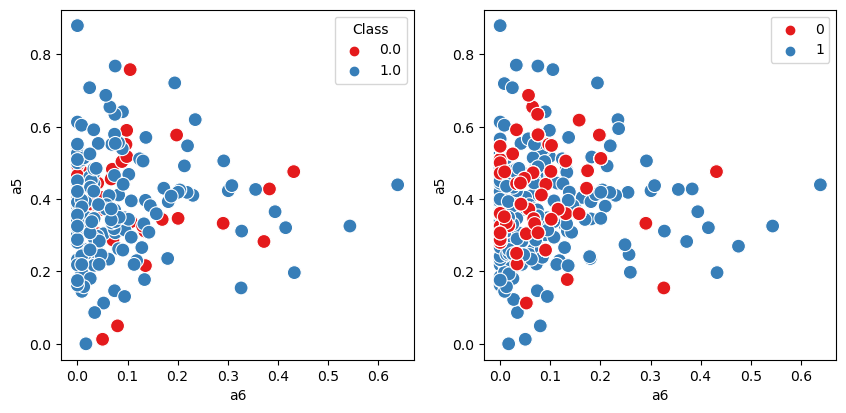

In [205]:
features_before_sampling = features_train.copy(deep=True)
target_before_sampling = target_train.copy(deep=True)
features_after_sampling, target_after_sampling = resemple_data(
    RandomOverSampler(random_state=random_state),
    "RandomOverSampler", 
    features_before_sampling,
    target_before_sampling,
)
cross_validating_score_all(classifiers, features_after_sampling, target_after_sampling)
scattering_matrix(
    features_after_sampling, 
    features_before_sampling, 
    target_after_sampling, 
    target_before_sampling, 
    "RandomOverSampling"
)

SMOTE

SMOTE
Initial data : Counter({1: 222, 0: 54})
Edited data : Counter({0: 222, 1: 222})
Classifier: LogisticRegression(C=10, random_state=42, solver='newton-cg')
balanced accuracy: 68.96%
accuracy: 68.91%
f1: 67.18%
fp: 12.83%
fn: 18.25%


Classifier: DecisionTreeClassifier(max_depth=9, max_features='auto', min_samples_leaf=4,
                       random_state=42)
balanced accuracy: 75.28%
accuracy: 75.24%
f1: 73.95%
fp: 9.89%
fn: 14.87%


Classifier: MLPClassifier(activation='logistic', alpha=0.01,
              hidden_layer_sizes=(50, 50, 50), random_state=42, solver='sgd')
balanced accuracy: 50.0%
accuracy: 50.0%
f1: 66.66%
fp: 50.0%
fn: 0.0%


Classifier: MultinomialNB(alpha=0.1, fit_prior=False)
balanced accuracy: 61.08%
accuracy: 61.01%
f1: 57.26%
fp: 15.31%
fn: 23.68%


Classifier: SVC(C=3, class_weight='balanced', kernel='linear', random_state=42)
balanced accuracy: 71.01%
accuracy: 70.94%
f1: 66.15%
fp: 8.09%
fn: 20.96%


Training data before and after used SMOTE


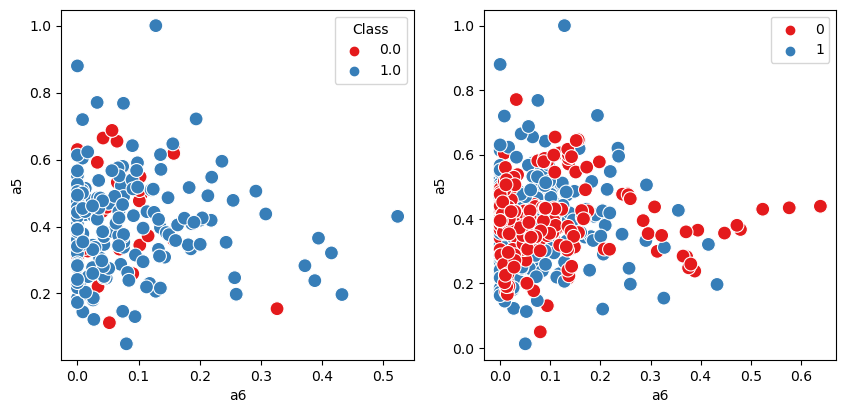

In [171]:
features_before_sampling = features_train.copy(deep=True)
target_before_sampling = target_train.copy(deep=True)
features_after_sampling, target_after_sampling = resemple_data(
    SMOTE(k_neighbors=3, n_jobs=-1, random_state=random_state),
    "SMOTE", 
    features_before_sampling,
    target_before_sampling,
)
cross_validating_score_all(classifiers, features_after_sampling, target_after_sampling)
scattering_matrix(
    features_after_sampling, 
    features_before_sampling, 
    target_after_sampling, 
    target_before_sampling, 
    "SMOTE"
)

ADASYN

ADASYN
Initial data : Counter({1: 222, 0: 54})
Edited data : Counter({0: 224, 1: 222})
Classifier: LogisticRegression(C=10, random_state=42, solver='newton-cg')
balanced accuracy: 63.71%
accuracy: 63.7%
f1: 62.2%
fp: 16.57%
fn: 19.73%


Classifier: DecisionTreeClassifier(max_depth=9, max_features='auto', min_samples_leaf=4,
                       random_state=42)
balanced accuracy: 67.26%
accuracy: 67.28%
f1: 68.21%
fp: 17.72%
fn: 15.0%


Classifier: MLPClassifier(activation='logistic', alpha=0.01,
              hidden_layer_sizes=(50, 50, 50), random_state=42, solver='sgd')
balanced accuracy: 50.0%
accuracy: 50.67%
f1: 40.2%
fp: 29.78%
fn: 19.56%


Classifier: MultinomialNB(alpha=0.1, fit_prior=False)
balanced accuracy: 55.31%
accuracy: 55.36%
f1: 53.43%
fp: 20.61%
fn: 24.03%


Classifier: SVC(C=3, class_weight='balanced', kernel='linear', random_state=42)
balanced accuracy: 63.42%
accuracy: 63.43%
f1: 58.78%
fp: 13.23%
fn: 23.34%


Training data before and after used ADASYN


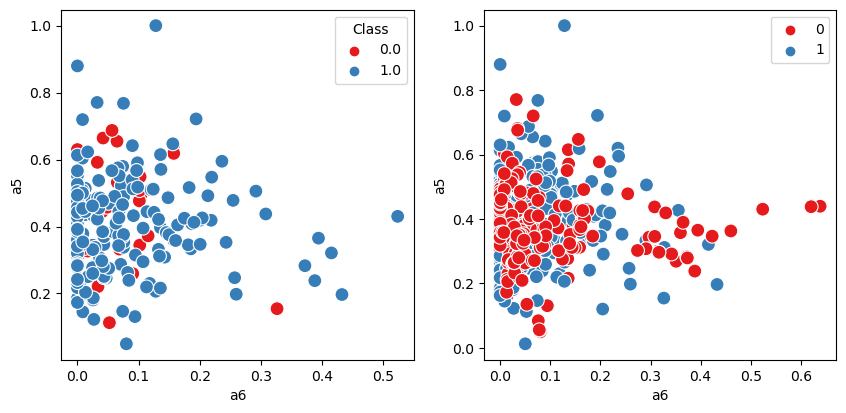

In [172]:
features_before_sampling = features_train.copy(deep=True)
target_before_sampling = target_train.copy(deep=True)
features_after_sampling, target_after_sampling = resemple_data(
    ADASYN(n_neighbors=2, n_jobs=-1, random_state=random_state),
    "ADASYN", 
    features_before_sampling,
    target_before_sampling,
)
cross_validating_score_all(classifiers, features_after_sampling, target_after_sampling)
scattering_matrix(
    features_after_sampling, 
    features_before_sampling, 
    target_after_sampling, 
    target_before_sampling, 
    "ADASYN"
)

Далее идут алгоритмы, направленные на сокращение данных (under-sampling), удаляют экземпляры наибольшего класса. Их главная задача - сократить наименее важные данные, чтобы точность модели не упала. Справляются с этой задачей они с различным успехом, зависящим от конкретных данных.

RandomUnderSampler

RandomUnderSampler
Initial data : Counter({1: 222, 0: 54})
Edited data : Counter({0: 54, 1: 54})
Classifier: LogisticRegression(C=10, penalty='l1', random_state=42, solver='saga')
balanced accuracy: 69.17%
accuracy: 69.45%
f1: 68.7%
fp: 31.67%
fn: 30.0%


Classifier: DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=4,
                       min_samples_split=10, random_state=42)
balanced accuracy: 65.17%
accuracy: 64.91%
f1: 60.88%
fp: 25.67%
fn: 44.0%


Classifier: MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50, 50),
              random_state=42)
balanced accuracy: 72.33%
accuracy: 72.18%
f1: 72.77%
fp: 32.67%
fn: 22.67%


Classifier: MultinomialNB(alpha=0.1, fit_prior=False)
balanced accuracy: 64.83%
accuracy: 65.55%
f1: 65.2%
fp: 41.67%
fn: 28.67%


Classifier: SVC(C=3, class_weight='balanced', kernel='linear', random_state=42)
balanced accuracy: 68.33%
accuracy: 68.36%
f1: 66.43%
fp: 37.0%
fn: 26.33%


Training data before and after used Rando

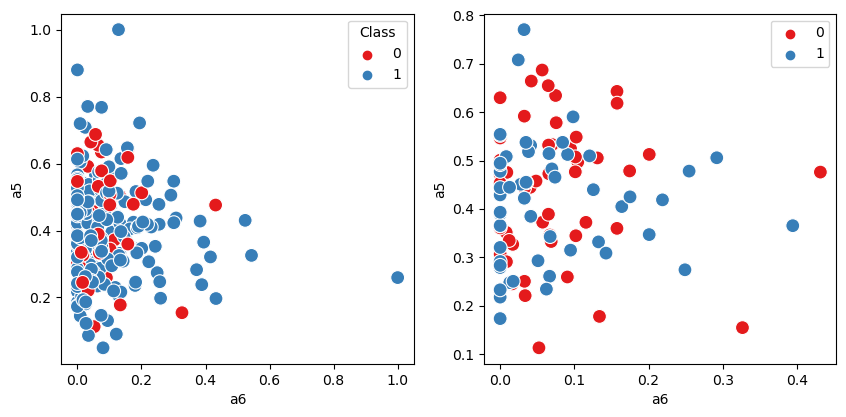

In [113]:
features_before_sampling = features_train.copy(deep=True)
target_before_sampling = target_train.copy(deep=True)
features_after_sampling, target_after_sampling = resemple_data(
    RandomUnderSampler(random_state=random_state),
    "RandomUnderSampler", 
    features_before_sampling,
    target_before_sampling,
)
cross_validating_score_all(classifiers, features_after_sampling, target_after_sampling)
scattering_matrix(
    features_after_sampling, 
    features_before_sampling, 
    target_after_sampling, 
    target_before_sampling, 
    "RandomUnderSampler"
)

CondensedNearestNeighbor

CondensedNearestNeighbour
Initial data : Counter({1: 222, 0: 54})
Edited data : Counter({1: 81, 0: 54})
Classifier: LogisticRegression(C=10, penalty='l1', random_state=42, solver='saga')
balanced accuracy: 71.86%
accuracy: 74.95%
f1: 80.58%
fp: 42.67%
fn: 13.61%


Classifier: DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=4,
                       min_samples_split=10, random_state=42)
balanced accuracy: 53.81%
accuracy: 55.38%
f1: 60.04%
fp: 52.67%
fn: 39.72%


Classifier: MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50, 50),
              random_state=42)
balanced accuracy: 70.78%
accuracy: 73.41%
f1: 78.99%
fp: 42.33%
fn: 16.11%


Classifier: MultinomialNB(alpha=0.1, fit_prior=False)
balanced accuracy: 64.82%
accuracy: 67.31%
f1: 73.69%
fp: 48.0%
fn: 22.36%


Classifier: SVC(C=3, class_weight='balanced', kernel='linear', random_state=42)
balanced accuracy: 70.07%
accuracy: 70.99%
f1: 74.87%
fp: 35.0%
fn: 24.86%


Training data before and after 

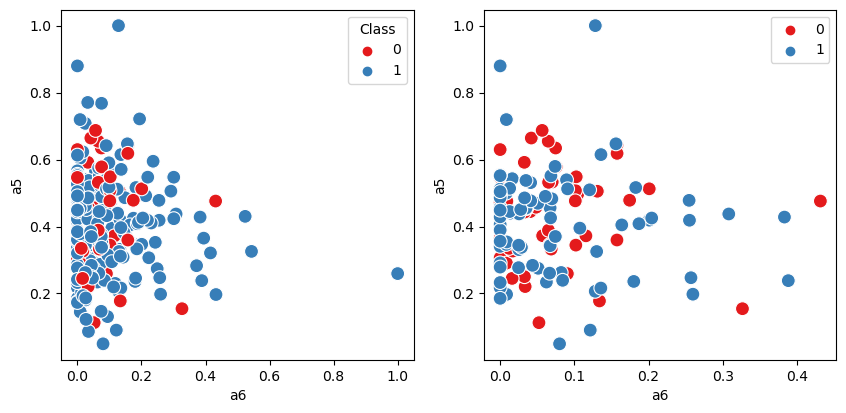

In [114]:
features_before_sampling = features_train.copy(deep=True)
target_before_sampling = target_train.copy(deep=True)
features_after_sampling, target_after_sampling = resemple_data(
    CondensedNearestNeighbour(sampling_strategy='not minority', n_neighbors=5, n_seeds_S=5, n_jobs=-1, random_state=random_state),
    "CondensedNearestNeighbour", 
    features_before_sampling,
    target_before_sampling,
)
cross_validating_score_all(classifiers, features_after_sampling, target_after_sampling)
scattering_matrix(
    features_after_sampling, 
    features_before_sampling, 
    target_after_sampling, 
    target_before_sampling, 
    "CondensedNearestNeighbour"
)

TomekLinks

TomekLinks
Initial data : Counter({1: 222, 0: 54})
Edited data : Counter({1: 222, 0: 43})
Classifier: LogisticRegression(C=10, penalty='l1', random_state=42, solver='saga')
balanced accuracy: 73.16%
accuracy: 89.49%
f1: 93.93%
fp: 51.0%
fn: 2.69%


Classifier: DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=4,
                       min_samples_split=10, random_state=42)
balanced accuracy: 63.26%
accuracy: 82.32%
f1: 89.45%
fp: 64.5%
fn: 8.97%


Classifier: MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50, 50),
              random_state=42)
balanced accuracy: 73.95%
accuracy: 89.12%
f1: 93.65%
fp: 48.5%
fn: 3.6%


Classifier: MultinomialNB(alpha=0.1, fit_prior=False)
balanced accuracy: 70.67%
accuracy: 76.23%
f1: 84.7%
fp: 37.5%
fn: 21.17%


Classifier: SVC(C=3, class_weight='balanced', kernel='linear', random_state=42)
balanced accuracy: 78.76%
accuracy: 80.8%
f1: 87.62%
fp: 24.5%
fn: 17.98%


Training data before and after used TomekLinks


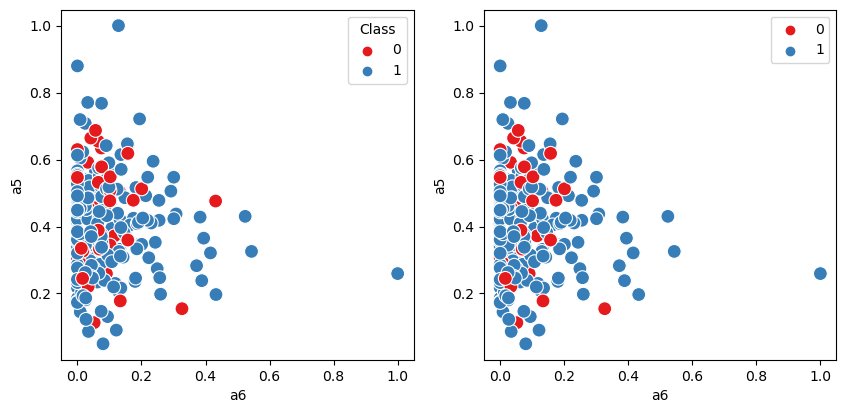

In [115]:
features_before_sampling = features_train.copy(deep=True)
target_before_sampling = target_train.copy(deep=True)
features_after_sampling, target_after_sampling = resemple_data(
    TomekLinks(sampling_strategy='not majority', n_jobs=-1),
    "TomekLinks", 
    features_before_sampling,
    target_before_sampling,
)
cross_validating_score_all(classifiers, features_after_sampling, target_after_sampling)
scattering_matrix(
    features_after_sampling, 
    features_before_sampling, 
    target_after_sampling, 
    target_before_sampling, 
    "TomekLinks"
)

ClusterCentroids

ClusterCentroids
Initial data : Counter({1: 222, 0: 54})
Edited data : Counter({0: 54, 1: 54})
Classifier: LogisticRegression(C=10, penalty='l1', random_state=42, solver='saga')
balanced accuracy: 73.67%
accuracy: 73.82%
f1: 72.14%
fp: 27.67%
fn: 25.0%


Classifier: DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=4,
                       min_samples_split=10, random_state=42)
balanced accuracy: 65.17%
accuracy: 64.91%
f1: 63.92%
fp: 31.33%
fn: 38.33%


Classifier: MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50, 50),
              random_state=42)
balanced accuracy: 72.83%
accuracy: 73.09%
f1: 73.38%
fp: 31.67%
fn: 22.67%


Classifier: MultinomialNB(alpha=0.1, fit_prior=False)
balanced accuracy: 68.5%
accuracy: 68.45%
f1: 66.2%
fp: 26.0%
fn: 37.0%


Classifier: SVC(C=3, class_weight='balanced', kernel='linear', random_state=42)
balanced accuracy: 74.67%
accuracy: 74.82%
f1: 72.7%
fp: 24.0%
fn: 26.67%


Training data before and after used ClusterCe

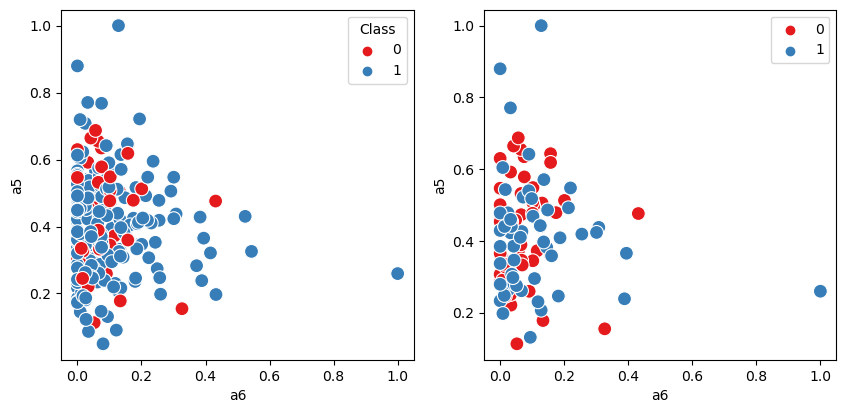

In [116]:
features_before_sampling = features_train.copy(deep=True)
target_before_sampling = target_train.copy(deep=True)
features_after_sampling, target_after_sampling = resemple_data(
    ClusterCentroids(sampling_strategy='not minority', voting='hard', random_state=random_state),
    "ClusterCentroids", 
    features_before_sampling,
    target_before_sampling,
)
cross_validating_score_all(classifiers, features_after_sampling, target_after_sampling)
scattering_matrix(
    features_after_sampling, 
    features_before_sampling, 
    target_after_sampling, 
    target_before_sampling, 
    "ClusterCentroids"
)

Далее идут комбинированные алгоритмы, которые используют как over-sampling так и under-sampling.

SMOTEENN

SMOTEENN
Initial data : Counter({1: 222, 0: 54})
Edited data : Counter({0: 194, 1: 107})
Classifier: LogisticRegression(C=10, penalty='l1', random_state=42, solver='saga')
balanced accuracy: 83.04%
accuracy: 84.71%
f1: 78.05%
fp: 10.74%
fn: 23.18%


Classifier: DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=4,
                       min_samples_split=10, random_state=42)
balanced accuracy: 80.79%
accuracy: 83.72%
f1: 74.82%
fp: 9.24%
fn: 29.18%


Classifier: MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50, 50),
              random_state=42)
balanced accuracy: 83.61%
accuracy: 85.38%
f1: 78.63%
fp: 9.68%
fn: 23.09%


Classifier: MultinomialNB(alpha=0.1, fit_prior=False)
balanced accuracy: 78.26%
accuracy: 78.42%
f1: 71.54%
fp: 20.47%
fn: 23.0%


Classifier: SVC(C=3, class_weight='balanced', kernel='linear', random_state=42)
balanced accuracy: 84.47%
accuracy: 84.39%
f1: 79.33%
fp: 15.42%
fn: 15.64%


Training data before and after used SMOTEENN


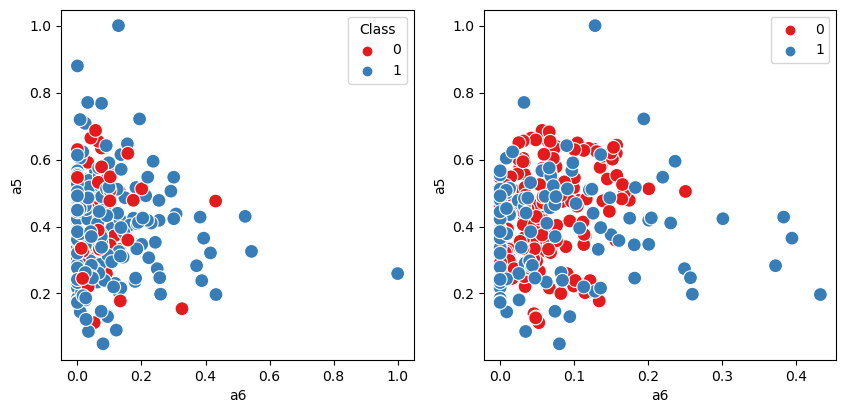

In [117]:
features_before_sampling = features_train.copy(deep=True)
target_before_sampling = target_train.copy(deep=True)
features_after_sampling, target_after_sampling = resemple_data(
    SMOTEENN(sampling_strategy='auto', random_state=random_state),
    "SMOTEENN", 
    features_before_sampling,
    target_before_sampling,
)
cross_validating_score_all(classifiers, features_after_sampling, target_after_sampling)
scattering_matrix(
    features_after_sampling, 
    features_before_sampling, 
    target_after_sampling, 
    target_before_sampling, 
    "SMOTEENN"
)

SMOTETomek

SMOTETomek
Initial data : Counter({1: 222, 0: 54})
Edited data : Counter({0: 222, 1: 222})
Classifier: LogisticRegression(C=10, penalty='l1', random_state=42, solver='saga')
balanced accuracy: 81.38%
accuracy: 81.34%
f1: 81.5%
fp: 19.25%
fn: 17.98%


Classifier: DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=4,
                       min_samples_split=10, random_state=42)
balanced accuracy: 76.59%
accuracy: 76.59%
f1: 75.26%
fp: 18.4%
fn: 28.42%


Classifier: MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50, 50),
              random_state=42)
balanced accuracy: 81.82%
accuracy: 81.79%
f1: 81.73%
fp: 17.92%
fn: 18.44%


Classifier: MultinomialNB(alpha=0.1, fit_prior=False)
balanced accuracy: 74.15%
accuracy: 74.13%
f1: 75.19%
fp: 30.08%
fn: 21.62%


Classifier: SVC(C=3, class_weight='balanced', kernel='linear', random_state=42)
balanced accuracy: 79.32%
accuracy: 79.3%
f1: 79.62%
fp: 22.43%
fn: 18.93%


Training data before and after used SMOTETome

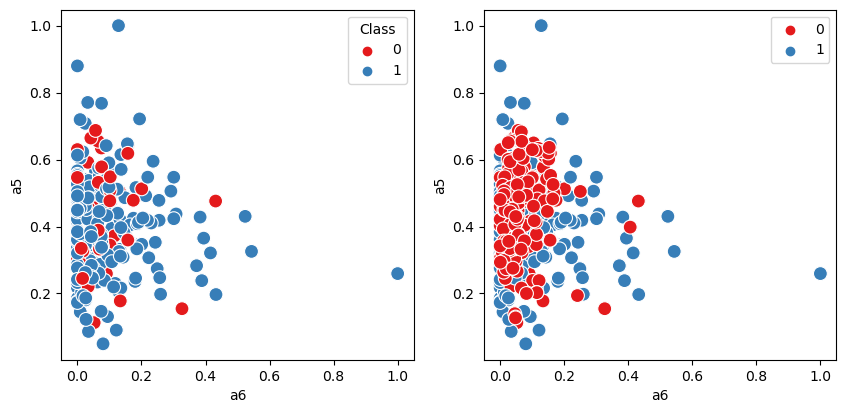

In [118]:
features_before_sampling = features_train.copy(deep=True)
target_before_sampling = target_train.copy(deep=True)
features_after_sampling, target_after_sampling = resemple_data(
    SMOTETomek(sampling_strategy='auto', random_state=random_state),
    "SMOTETomek", 
    features_before_sampling,
    target_before_sampling,
)
cross_validating_score_all(classifiers, features_after_sampling, target_after_sampling)
scattering_matrix(
    features_after_sampling, 
    features_before_sampling, 
    target_after_sampling, 
    target_before_sampling, 
    "SMOTETomek"
)